# Importing Packages

In [2]:
# Installing Packages
!{sys.executable} -m pip install nba_api --quiet
!{sys.executable} -m pip install pandas --quiet
!{sys.executable} -m pip install tqdm --quiet

#Importing packages
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playbyplayv2
import requests, pandas as pd, sys
from tqdm import tqdm
import dateutil.parser as parser
import numpy as np
import time
import seaborn as sns
from datetime import datetime,  timedelta
from scipy import stats
import plotly.express as px

# Setting Pandas option to show all columns

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 25)

# Creating Function for API pull

### Setting parameters for data pull

In [3]:
#Creating header var for api pull
headers: dict[str, str]  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

### Function that Pulls API data

In [4]:
# create function that gets pbp (play by play) logs from the 2021-22 season
def get_data(game_id) -> pd.DataFrame:
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

### Defining parameters for data pull

In [5]:
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2021-22',
                                               league_id_nullable='00',
                                               season_type_nullable='Regular Season')

## Retrieving Game Ids

## List of unique game ids for 2021-2022 season

In [6]:
# # Retrieving all game dataframes to get unique game ids
# games = gamefinder.get_data_frames()[0]

# #getting a list of distinct game ids
# game_ids = games['GAME_ID'].unique()

# # Setting an empty list for the game information
# pbpdata = []

# #Here TDQM() creates a % completion bar
# for game_id in tqdm(game_ids):
#     game_data: pd.DataFrame = get_data(game_id)
#     pbpdata.append(game_data)

# final_df: pd.DataFrame = pd.concat(pbpdata, ignore_index=True)

100%|██████████| 1230/1230 [17:59<00:00,  1.14it/s] 


### Section to read data in manually from local storage

In [64]:
# final_df.to_csv(r'nba_data.csv')

In [ ]:
### Removing index from data
# pd.read_csv('nba_data.csv', index_col=0)

In [3]:
final_df = pd.read_csv('nba_data.csv')

# Instantiating Data Frame

In [7]:
final_df_copy: pd.DataFrame = pd.DataFrame(final_df)

### Checking Data Loaded in Properly

In [8]:
print(len(final_df))
print(len(final_df['gameid'].unique()))

691875
1230


## Reviewing Column Names

In [9]:
#Primary columns in the DF
final_df_copy.columns

Index(['Unnamed: 0', 'actionNumber', 'clock', 'timeActual', 'period',
       'periodType', 'actionType', 'subType', 'qualifiers', 'personId', 'x',
       'y', 'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description',
       'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'shotDistance',
       'shotResult', 'pointsTotal', 'assistPlayerNameInitial',
       'assistPersonId', 'assistTotal', 'blockPlayerName', 'blockPersonId',
       'shotActionNumber', 'reboundTotal', 'reboundDefensiveTotal',
       'reboundOffensiveTotal', 'turnoverTotal', 'stealPlayerName',
       'stealPersonId', 'officialId', 'foulPersonalTotal',
       'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId',
       'value', 'gam

In [10]:
final_df_copy.head(10)

,Unnamed: 0,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,...,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,value,gameid,dateGameStarted,period_to_time,time_passed_in_seconds,Total_time_passed_in_game
0,0,2,PT12M00.00S,2022-04-10T19:45:26.5Z,1,REGULAR,period,start,[],0,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:00,1900-01-01 00:00:00
1,1,4,PT11M55.00S,2022-04-10T19:45:29.9Z,1,REGULAR,jumpball,recovered,[],1628971,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:05,1900-01-01 00:00:05
2,2,7,PT11M38.00S,2022-04-10T19:45:47.5Z,1,REGULAR,2pt,DUNK,['pointsinthepaint'],203083,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:22,1900-01-01 00:00:22
3,3,9,PT11M14.00S,2022-04-10T19:46:11.9Z,1,REGULAR,2pt,Jump Shot,['pointsinthepaint'],204456,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:46,1900-01-01 00:00:46
4,4,10,PT11M14.00S,2022-04-10T19:46:11.9Z,1,REGULAR,block,NaN,[],203083,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:46,1900-01-01 00:00:46
5,5,11,PT11M11.00S,2022-04-10T19:46:14.9Z,1,REGULAR,rebound,defensive,[],203083,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:49,1900-01-01 00:00:49
6,6,12,PT11M06.00S,2022-04-10T19:46:19.6Z,1,REGULAR,2pt,Layup,"['pointsinthepaint', 'fastbreak']",1630556,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:00:54,1900-01-01 00:00:54
7,7,14,PT10M57.00S,2022-04-10T19:46:28.7Z,1,REGULAR,3pt,Jump Shot,[],1627741,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:01:03,1900-01-01 00:01:03
8,8,15,PT10M54.00S,2022-04-10T19:46:31.7Z,1,REGULAR,rebound,defensive,[],203083,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:01:06,1900-01-01 00:01:06
9,9,16,PT10M45.00S,2022-04-10T19:46:40.8Z,1,REGULAR,2pt,Jump Shot,['pointsinthepaint'],202681,...,NaN,NaN,NaN,NaN,NaN,22101216,2022-04-10,0,0 days 00:01:15,1900-01-01 00:01:15


In [11]:
round(final_df_copy.describe(),2)

,Unnamed: 0,actionNumber,period,personId,x,y,possession,scoreHome,scoreAway,orderNumber,...,reboundDefensiveTotal,reboundOffensiveTotal,turnoverTotal,stealPersonId,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPersonId,gameid,period_to_time
count,691875.00,691875.00,691875.00,691875.00,216713.00,216713.00,6.918750e+05,691875.00,691875.00,691875.00,...,109347.00,109347.00,32102.00,18760.00,68328.00,49746.00,49746.00,48306.00,691875.00,691875.00
mean,345937.00,338.34,2.55,1031515.59,49.97,49.58,1.604646e+09,57.46,56.57,3322917.73,...,3.07,0.95,1.91,1155470.45,451530.93,2.00,0.06,1095784.55,22100612.83,18.49
std,199727.25,194.28,1.13,727511.82,35.59,22.92,9.784667e+07,33.28,32.82,1906753.10,...,2.46,1.27,1.21,675106.34,642715.93,1.13,0.25,693557.15,354.98,13.38
min,0.00,2.00,1.00,0.00,0.21,0.00,0.000000e+00,0.00,0.00,20000.00,...,0.00,0.00,1.00,2544.00,1146.00,0.00,0.00,2544.00,22100001.00,0.00
25%,172968.50,170.00,2.00,203076.00,11.56,39.46,1.610613e+09,29.00,29.00,1680000.00,...,1.00,0.00,1.00,203501.00,2005.00,1.00,0.00,203496.00,22100305.00,12.00
50%,345937.00,336.00,3.00,1627759.00,57.51,50.00,1.610613e+09,57.00,56.00,3300000.00,...,2.00,1.00,1.00,1628374.00,201640.00,2.00,0.00,1627814.00,22100612.00,24.00
75%,518905.50,503.00,4.00,1629632.00,88.35,59.07,1.610613e+09,85.00,84.00,4940000.00,...,4.00,1.00,2.00,1629655.00,204058.00,3.00,0.00,1629630.00,22100919.00,36.00
max,691874.00,893.00,7.00,1630994.00,99.82,99.75,1.610613e+09,153.00,158.00,8750000.00,...,21.00,12.00,10.00,1630994.00,1629422.00,6.00,3.00,1630994.00,22101230.00,36.00


# _Data Manipulation and Formating_

### Checking data types

In [12]:
### Transforming data types
dict(final_df_copy.dtypes)

{'Unnamed: 0': dtype('int64'),
 'actionNumber': dtype('int64'),
 'clock': dtype('O'),
 'timeActual': dtype('O'),
 'period': dtype('int64'),
 'periodType': dtype('O'),
 'actionType': dtype('O'),
 'subType': dtype('O'),
 'qualifiers': dtype('O'),
 'personId': dtype('int64'),
 'x': dtype('float64'),
 'y': dtype('float64'),
 'possession': dtype('int64'),
 'scoreHome': dtype('int64'),
 'scoreAway': dtype('int64'),
 'edited': dtype('O'),
 'orderNumber': dtype('int64'),
 'xLegacy': dtype('float64'),
 'yLegacy': dtype('float64'),
 'isFieldGoal': dtype('int64'),
 'side': dtype('O'),
 'description': dtype('O'),
 'personIdsFilter': dtype('O'),
 'teamId': dtype('float64'),
 'teamTricode': dtype('O'),
 'descriptor': dtype('O'),
 'jumpBallRecoveredName': dtype('O'),
 'jumpBallRecoverdPersonId': dtype('float64'),
 'playerName': dtype('O'),
 'playerNameI': dtype('O'),
 'jumpBallWonPlayerName': dtype('O'),
 'jumpBallWonPersonId': dtype('float64'),
 'jumpBallLostPlayerName': dtype('O'),
 'jumpBallLostPe

## Time Conversion Functions
#### "Time Passed in Game" = the total time passed within a game (Format: Min:Sec)
#### "Date of Game" = The minimum date that a game started on (if a game starts on 04/05/22 and goes into 04/06/23 the game started on 04/05/23)

In [13]:
# creating a date column
final_df_copy['dateGameStarted'] = pd.to_datetime(final_df_copy.timeActual).dt.date

def period_to_time_conversion(value) -> int:
    """Takes in a number value of 1/2/3/4 and returns the total time passed in minutes for that given input"""
    if value == 1:
        return 0
    elif value == 2:
        return 12
    elif value == 3:
        return 24
    else:
        return 36

# Formating clock column to total time passed in game
def time_conversion(unparsed_timearray):
    """ Takes in an array of datetime values representing of time to go in a given period and returns time passed in the period """
    x = datetime(year =1900, month=1, day=1, hour=0, minute=12, second=0)
    values_array = unparsed_timearray[0:7]
    time_passed_total = x - pd.to_datetime(values_array, format='PT%MM%S')
    return time_passed_total


# Creating a function to create new column with total time passed in game
def total_time_passed(period_finished_minutes, minutes_passed_within_period):
    """Takes in total_time_passed_in_period and period_to_time and returns the combined values to get the total time passed in game"""
    period_minutes = pd.to_datetime(period_finished_minutes, format='%M')
    minutes_within_period = minutes_passed_within_period
    return period_minutes + minutes_within_period

### Calling Time Conversion Functions

In [14]:
final_df_copy['period_to_time'] = final_df_copy['period'].map(period_to_time_conversion)
final_df_copy['time_passed_in_seconds'] = final_df_copy['clock'].map(time_conversion)
final_df_copy['Total_time_passed_in_game'] = list(map(total_time_passed, final_df_copy.period_to_time, final_df_copy.time_passed_in_seconds))

# NOT SURE HOW TO APLY A MIN() function to the gamestarted date to get the earliest date per game aka the date gamestarted

In [30]:
# (final_df_copy.gameid).unique()

final_df_copy[final_df_copy.gameid == 22100006]
# final_df_copy['dateGameStarted'].head(100)

test=final_df_copy[final_df_copy.gameid == 22100006].groupby(['teamId', 'gameid', 'actionNumber', 'timeActual'])['dateGameStarted'].min()

In [31]:
test

teamId        gameid    actionNumber  timeActual            
1.610613e+09  22100006  4             2021-10-20T23:47:11.1Z    2021-10-20
                        7             2021-10-20T23:47:21.4Z    2021-10-20
                        10            2021-10-20T23:47:45.6Z    2021-10-20
                        11            2021-10-20T23:48:02.2Z    2021-10-20
                        14            2021-10-20T23:48:31.2Z    2021-10-20
                                                                   ...    
                        707           2021-10-21T02:01:52.7Z    2021-10-21
                        709           2021-10-21T02:01:59.5Z    2021-10-21
                        712           2021-10-21T02:02:26.0Z    2021-10-21
                        714           2021-10-21T01:57:04.1Z    2021-10-21
                        716           2021-10-21T01:53:01.4Z    2021-10-21
Name: dateGameStarted, Length: 610, dtype: object

### Creating a new data fame with players removed if they do not pass conditions:
-  play atleast 20 games AND have more than 10 combined PTS/REB/AST avg per game

In [15]:
### Getting games played per player
player_games_played: pd.DataFrame = final_df_copy[['gameid','playerNameI', 'personId']].groupby(['personId', 'playerNameI'], as_index=False).nunique().sort_values('gameid', ascending=False)

### Filtering DF to only include 20+ games
players_with_20more_games = player_games_played[player_games_played.gameid >= 20].personId

### Getting AVG PTS+REB+AST per game per player
player_stats_threshold: pd.DataFrame = final_df_copy[['gameid','playerNameI', 'personId', 'pointsTotal', 'assistTotal', 'reboundTotal']].groupby(['personId', 'playerNameI', 'gameid'], as_index=False).max().sort_values('gameid', ascending=False)
player_stats_threshold['combined_totals'] = player_stats_threshold.iloc[:, 3:].sum(axis=1)
player_stats_threshold_avgs = player_stats_threshold.groupby(['personId', 'playerNameI'], as_index=False)['combined_totals'].mean()

### Getting DF with players who have combinedtstats >= 10
player_stats_threshold_id_list = player_stats_threshold_avgs[player_stats_threshold_avgs.combined_totals >= 10]

### Creating player_Id dataframe joining `player_stats_threshold_id_list` and `players_with_20more_games` to get the common players between these 2
joined_player_id_list = pd.merge(player_stats_threshold_id_list, players_with_20more_games, how='inner', on=['personId']).personId

### Creating New DF with only players 20 games+ and 10 total points/rbs/assists avg per game

In [16]:
df_players_removed: pd.DataFrame = final_df_copy.query('personId in @joined_player_id_list')

### Preping a mapping dict for player names and Player Ids

In [17]:
#Changing column to int data type
df_players_removed.assistPersonId = final_df_copy.assistPersonId.astype('Int64')

# Creating a dict for mapping object of names and ids
playerid_and_player_initials_dict_assists =dict(zip(df_players_removed.assistPlayerNameInitial.values, df_players_removed.assistPersonId))
playerid_and_player_initials_dict_playername_to_personid =dict(zip(df_players_removed.playerNameI.values, df_players_removed.personId))
playerid_and_player_initials_dict_combined = playerid_and_player_initials_dict_assists | playerid_and_player_initials_dict_playername_to_personid

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_14478/4111727379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_removed.assistPersonId = final_df_copy.assistPersonId.astype('Int64')


# Data Frame Fuctions
## Creating TS% (true shooting percetage) data frame Per Game

In [18]:
def ts_perc_dataframe_creation(input_dataframe: pd.DataFrame)-> pd.DataFrame:        
        """Takes in a dataframe and transforms the data and returns a dataframe with information about player TS% per game

        Additional information here
        """
        
        df_most_info: pd.DataFrame = input_dataframe\
                .groupby(['playerNameI','gameid', 'personId'], as_index=False)\
                .agg({'isFieldGoal':np.sum,\
                'dateGameStarted':np.min,\
                'pointsTotal': np.max,})

        df_fta = input_dataframe[ ((input_dataframe.actionType == 'freethrow'))]\
                .groupby(['playerNameI','personId','gameid', 'actionType'], as_index=False)['actionType'].count()
                # .agg({'actionType': 'sum'})

        #Merging DFs on columns gameid and playernamei
        combined_df_all_metrics: pd.DataFrame = pd.merge(df_most_info, df_fta, how='left', on=['personId','playerNameI','gameid'])

        # Renaming Column Names
        combined_df_all_metrics = combined_df_all_metrics.rename(columns={'isFieldGoal':'FGA', 'actionType':'FTA'})

        # Moving columns to a better order
        cols: list[str] = ['dateGameStarted', 'gameid', 'playerNameI', 'pointsTotal', 'FGA', 'FTA']
        combined_df_all_metrics = combined_df_all_metrics[cols]

        # Replacing Nans in the DF with 0s
        combined_df_all_metrics =combined_df_all_metrics.fillna(0)

        # Creating TS% column
        combined_df_all_metrics['TS%'] = round((combined_df_all_metrics['pointsTotal'])/\
                        (2*((combined_df_all_metrics['FGA'])+ (combined_df_all_metrics['FTA']*.44))) * 100,3)
        
        return combined_df_all_metrics

### Calling TS% Per Game Function

In [19]:
df_groupby = ts_perc_dataframe_creation(df_players_removed)

In [21]:
df_groupby.sort_values(['TS%'], ascending=False).head()

#### Some of these dates are reflective of when the games actuallt occured
# Alex len, Zeke Nnaji

,dateGameStarted,gameid,playerNameI,pointsTotal,FGA,FTA,TS%
10022,2022-03-13,0022101010,J. Holiday,3.0,1,0.0,150.0
13994,2021-12-14,0022100404,L. Stevens,3.0,1,0.0,150.0
15456,2021-11-07,0022100141,M. Wagner,3.0,1,0.0,150.0
10343,2022-03-19,0022101047,J. Konchar,3.0,1,0.0,150.0
10334,2022-02-17,0022100879,J. Konchar,3.0,1,0.0,150.0


### Plotting TS% Distribution by Game Per Player

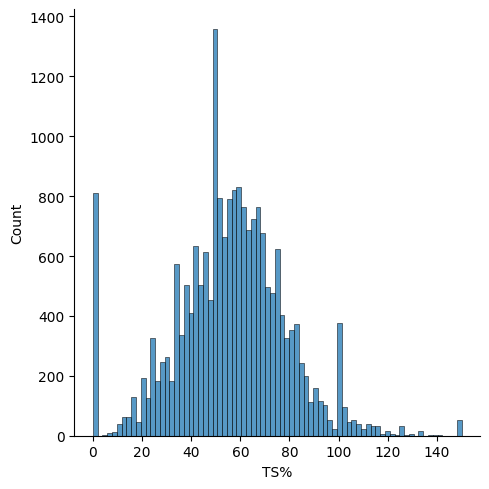

In [22]:
# Plotting distribution of TS%s of all players games in the 2021-2022 season
sns.displot(df_groupby, x='TS%');

## Creating TS% for by PLayer for the 2021-2022 Season

In [23]:
def ts_perc_dataframe_creation_whole_season(input_dataframe: pd.DataFrame)-> pd.DataFrame:
        """Takes in a dataframe and transforms the data and returns a dataframe with information about player TS% for the season

        Additional information here
        """
        
        ### Getting Shot Attemps for season
        df_most_info = input_dataframe\
                .groupby(['playerNameI', 'personId'], as_index=False)\
                .agg({'isFieldGoal':np.sum,\
                        'shotDistance':np.sum})

        ### Getting Points MAX per game
        df_points_per_game = input_dataframe\
                .groupby(['playerNameI','gameid', 'personId'], as_index=False)\
                .agg({'pointsTotal': np.max,})
        
        ### Getting sum of all points totals per game
        df_points_seaon_totals = df_points_per_game\
                .groupby(['playerNameI','personId'], as_index=False)\
                .agg({'pointsTotal': np.sum,})

        ### Getting Total FTAs
        df_fta = input_dataframe[ ((input_dataframe.actionType == 'freethrow'))]\
                .groupby(['playerNameI','personId', 'actionType'], as_index=False)['actionType'].count()

        # Merging most and total_points
        df_points_and_most = pd.merge(df_most_info, df_points_seaon_totals, how='inner', on=['personId','playerNameI',])

        #Merging DFs on columns playernamei and personId
        combined_df_all_metrics_season = pd.merge(df_points_and_most, df_fta, how='left', on=['personId','playerNameI',])

        # Renaming Column Names
        combined_df_all_metrics_season = combined_df_all_metrics_season.rename(columns={'isFieldGoal':'FGA', 'actionType':'FTA'})

        # Moving columns to a better order
        cols: list[str] = ['playerNameI', 'pointsTotal', 'FGA', 'FTA', 'shotDistance']
        combined_df_all_metrics_season = combined_df_all_metrics_season[cols]

        # Replacing Nans in the DF with 0s
        combined_df_all_metrics_season =combined_df_all_metrics_season.fillna(0)

        # Creating TS% column
        combined_df_all_metrics_season['TS%'] = round((combined_df_all_metrics_season['pointsTotal'])/\
                        (2*((combined_df_all_metrics_season['FGA'])+ (combined_df_all_metrics_season['FTA']*.44))) * 100,3)

        ### Getting AVG shot distance per player for season
        combined_df_all_metrics_season['avg_shot_distance_FT'] = round(combined_df_all_metrics_season.shotDistance/combined_df_all_metrics_season.FGA,3)
        
        return combined_df_all_metrics_season

### Calling Season TS% Function

In [24]:
df_groupby_season = ts_perc_dataframe_creation_whole_season(df_players_removed)

In [53]:
df_groupby_season.head()

,playerNameI,pointsTotal,FGA,FTA,shotDistance,TS%,avg_shot_distance
0,A. Bradley,394.0,350,18,6317.45,55.040,18.050
1,A. Burks,944.0,728,264,12635.16,55.914,17.356
2,A. Caruso,304.0,257,73,3992.20,52.573,15.534
3,A. Coffey,619.0,466,117,7817.39,59.809,16.776
4,A. Davis,927.0,695,244,6686.61,57.767,9.621


### Plotting Season TS% for all players 2021-2022 Season

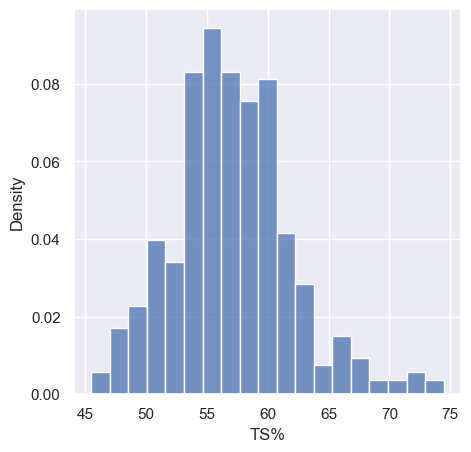

In [56]:
# Data
seaborn_plot = sns.histplot(df_groupby_season['TS%'], label='samples', stat='density')

## Plotting AVG Shot Distance against Season TS%

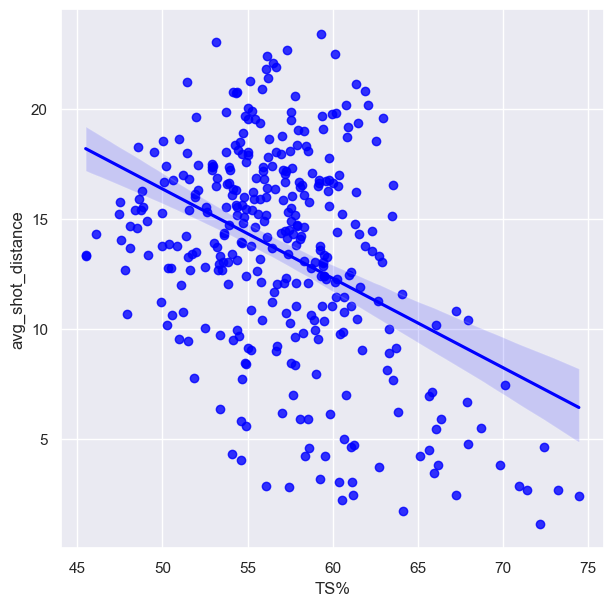

In [60]:
# Map TS% and average distance per shot for the whole season
sns.set(rc={'figure.figsize':(7,7)})
# sns.scatterplot(df_groupby_season, x='TS%', y='avg_shot_distance', color='blue')
sns.regplot(data=df_groupby_season, x='TS%', y='avg_shot_distance', color='blue');


## Analyzing % of shots missed and made by distance

In [28]:
# Creating 2 distributions of shots made from distance and shots missed from distance
# final_df_copy.shotDistance = final_df_copy.shotDistance.round(1)
df_shot_made = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Made'))][['shotDistance', 'shotResult', 'actionType']]
df_shot_missed = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Missed'))][['shotDistance', 'shotResult', 'actionType']]
df_shots_combined = pd.concat([df_shot_made, df_shot_missed])
df_shots_combined = df_shots_combined[df_shots_combined.shotDistance <= 46.0]

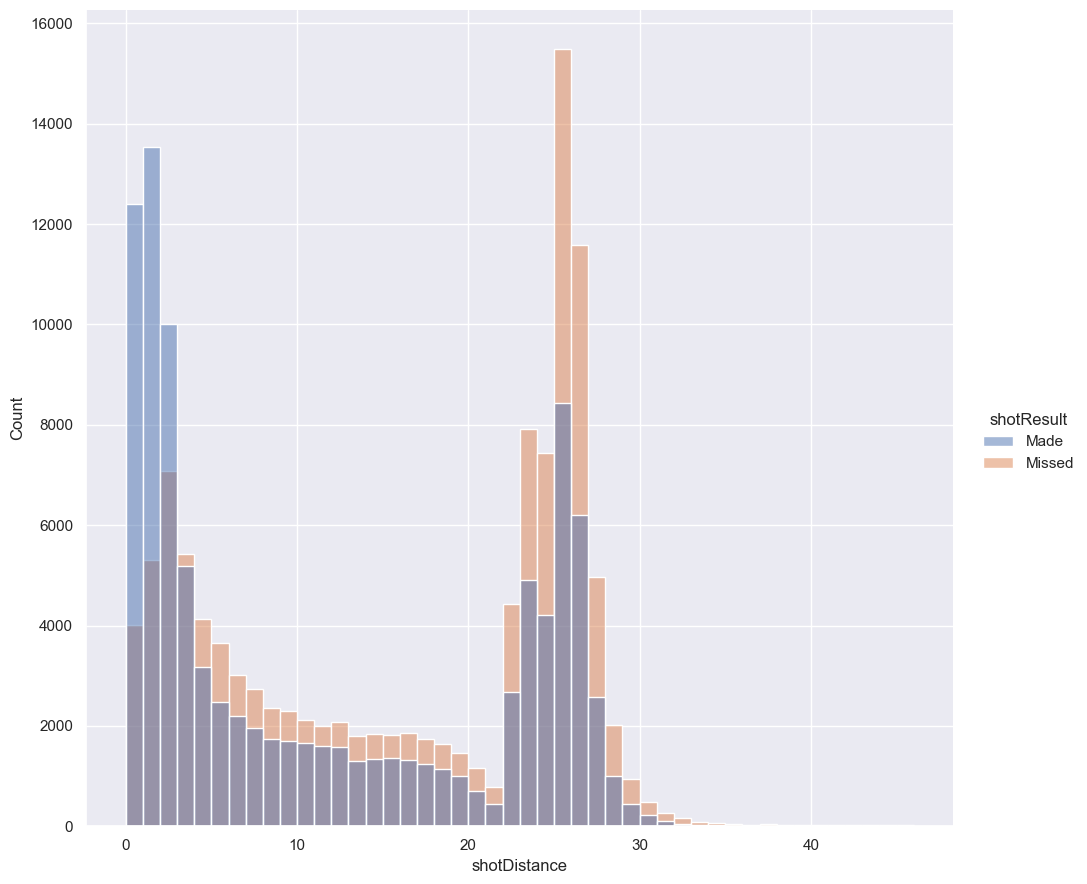

In [29]:
sns.set(rc={'figure.figsize':(5,5)})
sns.displot(df_shots_combined,x='shotDistance', binwidth=1, hue='shotResult', height=7, aspect=1.10);

# Get x axis to show ticks every 2 feet

## Analyzing Best players in the clutch
### % of team points and total points in clutch
#### Clutch is defined as games where teams are within 5 points under 5 minutes remaining

In [30]:
df_clutch = final_df_copy

# creating a date column
df_clutch['dateGameStarted'] = pd.to_datetime(df_clutch.timeActual).dt.date
# Using period_to_time_conversion function
df_clutch['period_to_time'] = df_clutch['period'].map(period_to_time_conversion)    
# Using time_conversion fucntion
df_clutch['time_passed_in_seconds'] = df_clutch['clock'].map(time_conversion)
# Using total_time_passed function
df_clutch['Total_time_passed_in_game'] = list(map(total_time_passed, df_clutch.period_to_time, df_clutch.time_passed_in_seconds))

### Changing Column Data Types For Analysis

In [31]:
df_clutch = df_clutch.astype({'scoreHome': 'int64', 'scoreAway':'int64'})

### Filtering clutch dataframe to only records within the last 5 minutes and within a 5 point +/- difference

In [32]:
df_clutch_final = df_clutch[(df_clutch['Total_time_passed_in_game'] >='1900-01-01 00:43:00' ) &\
                                     (abs(df_clutch['scoreHome']- df_clutch['scoreAway']) <= 5)]

In [33]:
df_clutch_final.head()

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,blockPlayerName,blockPersonId,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,turnoverTotal,stealPlayerName,stealPersonId,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,value,gameid,dateGameStarted,period_to_time,time_passed_in_seconds,Total_time_passed_in_game
2085,640,PT04M56.00S,2022-04-11T03:55:04.1Z,4,REGULAR,3pt,Jump Shot,[],1628370,76.691853,88.970588,1610612747,123,118,2022-04-11T03:55:08Z,6250000,195.0,167.0,1,right,M. Monk 25' 3PT (41 PTS) (A. Reaves 10 AST),"[1628370, 1630559]",1.610613e+09,LAL,NaN,NaN,NaN,Monk,M. Monk,NaN,NaN,NaN,NaN,25.64,Made,41.0,A. Reaves,1630559.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101220,2022-04-11,36,0 days 00:07:04,1900-01-01 00:43:04
2086,642,PT04M42.00S,2022-04-11T03:55:18.2Z,4,REGULAR,2pt,Layup,[pointsinthepaint],1627854,8.360710,42.647059,1610612743,123,118,2022-04-11T03:55:28Z,6270000,37.0,26.0,1,left,MISS B. Forbes driving Layup,[1627854],1.610613e+09,DEN,driving,NaN,NaN,Forbes,B. Forbes,NaN,NaN,NaN,NaN,4.51,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101220,2022-04-11,36,0 days 00:07:18,1900-01-01 00:43:18
2087,643,PT04M41.00S,2022-04-11T03:55:19.2Z,4,REGULAR,rebound,defensive,[],1629117,NaN,NaN,1610612747,123,118,2022-04-11T03:55:28Z,6280000,NaN,NaN,0,None,W. Gabriel REBOUND (Off:5 Def:4),[1629117],1.610613e+09,LAL,NaN,NaN,NaN,Gabriel,W. Gabriel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,642.0,9.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101220,2022-04-11,36,0 days 00:07:19,1900-01-01 00:43:19
2088,644,PT04M36.00S,2022-04-11T03:55:24.9Z,4,REGULAR,turnover,lost ball,[],1626169,NaN,NaN,1610612747,123,118,2022-04-11T03:55:31Z,6290000,NaN,NaN,0,None,S. Johnson lost ball TURNOVER (2 TO),"[1626169, 1630210]",1.610613e+09,LAL,NaN,NaN,NaN,Johnson,S. Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Howard,1630210.0,NaN,NaN,NaN,NaN,NaN,NaN,0022101220,2022-04-11,36,0 days 00:07:24,1900-01-01 00:43:24
2089,645,PT04M36.00S,2022-04-11T03:55:24.9Z,4,REGULAR,steal,NaN,[],1630210,NaN,NaN,1610612743,123,118,2022-04-11T03:55:26Z,6300000,NaN,NaN,0,None,M. Howard STEAL (1 STL),[1630210],1.610613e+09,DEN,NaN,NaN,NaN,Howard,M. Howard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101220,2022-04-11,36,0 days 00:07:24,1900-01-01 00:43:24


In [34]:
df_clutch_final[df_clutch_final['shotResult']=='Made']['actionType'].unique()

array(['3pt', 'freethrow', '2pt'], dtype=object)

## Creating a column for score value per action type

In [21]:
# Build out another column for each point scored per team
def score_per_shot_type(df) -> int:
    # """Takes in action type (shot) when the given action is "made" and returns a point value associated with the made shot"""
    if (df['shotResult'] == 'Made') & (df['actionType'] == 'freethrow'):
        return int(1)
    elif (df['shotResult'] == 'Made') & (df['actionType'] == '2pt'):
        return int(2)
    elif (df['shotResult'] == 'Made') & (df['actionType'] == '3pt'):
        return int(3)
    else:
        return int(0)

In [36]:
df_clutch_final['score_value'] = df_clutch_final.apply(score_per_shot_type, axis=1)

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_14478/3577904395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clutch_final['score_value'] = df_clutch_final.apply(score_per_shot_type, axis=1)


### Getting total team points in the clutch

In [37]:
# Get each teams total points scored in the clutch for the entire season
sum_total_points_in_clutch = df_clutch_final.groupby(['teamTricode', 'teamId']).agg({'score_value':np.sum}).reset_index()

### Getting total player points in the clutch

In [38]:
sum_total_points_per_player = df_clutch_final.groupby(['teamTricode', 'teamId', 'personId', 'playerNameI']).agg({'score_value':np.sum}).reset_index()

### Getting player points in clutch as a % of teams totals

In [39]:
combined_players_teams_points = sum_total_points_per_player.merge(sum_total_points_in_clutch,how='left', on=['teamTricode', 'teamId'], suffixes=('player_points', 'team_points'))
combined_players_teams_points['percentage_of_teams_total_clutch_points'] = round(combined_players_teams_points['score_valueplayer_points']/combined_players_teams_points['score_valueteam_points']*100,2)

In [40]:
combined_players_teams_points[combined_players_teams_points.percentage_of_teams_total_clutch_points > 30].sort_values('percentage_of_teams_total_clutch_points', ascending=False)

,teamTricode,teamId,personId,playerNameI,score_valueplayer_points,score_valueteam_points,percentage_of_teams_total_clutch_points
260,MEM,1.610613e+09,1629630,J. Morant,107,260,41.15
11,ATL,1.610613e+09,1629027,T. Young,118,291,40.55
129,DEN,1.610613e+09,203999,N. Jokic,147,371,39.62
70,CHI,1.610613e+09,201942,D. DeRozan,141,360,39.17
400,PHI,1.610613e+09,203954,J. Embiid,150,399,37.59
472,SAS,1.610613e+09,1627749,D. Murray,111,331,33.53
387,ORL,1.610613e+09,1630175,C. Anthony,87,280,31.07
305,MIN,1.610613e+09,1626156,D. Russell,80,263,30.42
121,DAL,1.610613e+09,1629029,L. Doncic,81,268,30.22


In [41]:
top_5_per_team = combined_players_teams_points.groupby(['teamId', 'teamTricode']).head(5)
top_5_per_team

,teamTricode,teamId,personId,playerNameI,score_valueplayer_points,score_valueteam_points,percentage_of_teams_total_clutch_points
0,ATL,1.610613e+09,101150,L. Williams,0,291,0.00
1,ATL,1.610613e+09,201568,D. Gallinari,14,291,4.81
2,ATL,1.610613e+09,203524,S. Hill,0,291,0.00
3,ATL,1.610613e+09,203991,C. Capela,23,291,7.90
4,ATL,1.610613e+09,203992,B. Bogdanovic,53,291,18.21
...,...,...,...,...,...,...,...
518,WAS,1.610613e+09,202397,I. Smith,0,371,0.00
519,WAS,1.610613e+09,202722,D. Bertans,4,371,1.08
520,WAS,1.610613e+09,203078,B. Beal,58,371,15.63
521,WAS,1.610613e+09,203107,T. Satoransky,4,371,1.08


## Plotting top 5 players per team clutch points % per team

In [63]:
px.scatter(top_5_per_team, x=top_5_per_team.teamTricode, y=top_5_per_team.percentage_of_teams_total_clutch_points, hover_data=['playerNameI'])

In [ ]:
#Notes for to dos for this data set
# --What duo had the most assits to dunks in the NBA
# --best assist to turn over ratio
# !!!!!!!!do one of those attribute hexagon charts where I plot 3pt, 2pt (type of 2 pt), and free throw % of each team!!!!!!!!!
    # 3pt%
    # 2pt%
    # FT%
    # Ass/turnover ratio




#############################################################################
# """
# Add Stats around TS and other stats like variability and a distribution curve
# Plot it againts league average 
# Grab players that exhibit the most varibaility or the least
# """
#############################################################################

## Comparing Teams Stats with radar chart
- 3PT%, 2PT%, FT%, Assists/Turnovers ratio, Points

In [63]:
totals_df = final_df_copy 

## Defining Score functions

In [64]:
# def team_agg_stats(df) -> pd.DataFrame:
#     df['score_per_shot'] = df.apply(score_per_shot_type, axis=1)

    # df.groupby(['teamTricode'])['shotResult', 'actionType'].apply(lambda x: x[x.str.contains('RET')].count())

def get_count_scored_2pts(df):
    if ((df['shotResult'] == 'Made') & (df['actionType'] == '2pt')) == True:
        return 1
        
def get_count_taken_2pts(df):
    if ((df['shotResult'] == 'Missed') & (df['actionType'] == '2pt')) == True:
        return 1

def get_count_scored_3pts(df):
    if ((df['shotResult'] == 'Made') & (df['actionType'] == '3pt')) == True:
        return 1

def get_count_taken_3pts(df):
    if ((df['shotResult'] == 'Missed') & (df['actionType'] == '3pt')) == True:
        return 1

def get_count_taken_fts(df):
    if ((df['shotResult'] == 'Made') & (df['actionType'] == 'freethrow')) == True:
        return 1

def get_count_scored_fts(df):
    if ((df['shotResult'] == 'Missed') & (df['actionType'] == 'freethrow')) == True:
        return 1

def get_count_rebounds(df):
    if (df['actionType'] == 'rebound') == True:
        return 1


    # team_grouped_stats = df.groupby('teamTricode' )\
    #     .agg({
    #         'total_2pts_scored':sum((temp_df['shotResult'] == 'Made') & (temp_df['actionType'] == '2pt')),
    #         'total_2pts_taken':sum((temp_df['shotResult'] == 'Missed') & (temp_df['actionType'] == '2pt')),
    #         'total_3pts_scored':sum((temp_df['shotResult'] == 'Made') & (temp_df['actionType'] == '3pt')),
    #         'total_3pts_taken':sum((temp_df['shotResult'] == 'Missed') & (temp_df['actionType'] == '3pt')),
    #         'total_ft_scored':sum((temp_df['shotResult'] == 'Made') & (temp_df['actionType'] == 'freethrow')),
    #         'total_ft_taken':sum((temp_df['shotResult'] == 'Missed') & (temp_df['actionType'] == 'freethrow')),
    #         })

    # return team_grouped_stats

In [65]:
totals_df['total_2pts_scored'] = totals_df.apply(get_count_scored_2pts, axis=1)
totals_df['total_2pts_missed'] = totals_df.apply(get_count_taken_2pts, axis=1)
totals_df['total_3pts_scored'] = totals_df.apply(get_count_scored_3pts, axis=1)
totals_df['total_3pts_missed'] = totals_df.apply(get_count_taken_3pts, axis=1)
totals_df['total_ft_scored'] = totals_df.apply(get_count_scored_fts, axis=1)
totals_df['total_ft_missed'] = totals_df.apply(get_count_taken_fts, axis=1)
totals_df['points_value'] = totals_df.apply(score_per_shot_type, axis=1)
totals_df['total_rebounds'] = totals_df.apply(get_count_rebounds, axis=1)


## INspect the totals df as the made 2pts is not functioning properly

In [61]:
totals_df[totals_df.actionType == '2pt'][['shotResult', 'total_2pts_scored', 'actionType', 'subType']].head(10)

,shotResult,total_2pts_scored,actionType,subType
2,Made,1.0,2pt,DUNK
3,Missed,NaN,2pt,Jump Shot
6,Made,1.0,2pt,Layup
9,Made,1.0,2pt,Jump Shot
12,Made,1.0,2pt,Jump Shot
15,Made,1.0,2pt,Hook
16,Made,1.0,2pt,Layup
17,Missed,NaN,2pt,Jump Shot
21,Made,1.0,2pt,Layup
22,Missed,NaN,2pt,Jump Shot


In [72]:
grouped_total_df = totals_df.groupby('teamTricode')[['total_2pts_scored', 'total_2pts_missed', 'total_3pts_scored', 'total_3pts_missed'\
                                , 'total_ft_scored', 'total_ft_missed', 'points_value', 'total_rebounds']].agg(np.sum)

In [199]:
grouped_total_df['perc_2pt'] = round(grouped_total_df['total_2pts_scored']/(grouped_total_df['total_2pts_missed']+grouped_total_df['total_2pts_scored']), 4)
grouped_total_df['perc_3pt'] = round(grouped_total_df['total_3pts_scored']/(grouped_total_df['total_3pts_missed']+grouped_total_df['total_3pts_scored']), 4)
grouped_total_df['perc_ft'] = round(grouped_total_df['total_ft_scored']/(grouped_total_df['total_ft_missed']+grouped_total_df['total_ft_scored']), 4)

grouped_df_final = grouped_total_df[['perc_2pt', 'perc_3pt', 'perc_ft', 'total_rebounds', 'points_value']].reset_index()

In [206]:
from sklearn.preprocessing import MinMaxScaler

normalized_data = MinMaxScaler().fit_transform(grouped_df_final.iloc[:,1:])
normalized_df = pd.DataFrame(data=normalized_data,index=grouped_df_final['teamTricode'], columns=grouped_df_final.columns[1:])

In [211]:
normalized_df = normalized_df.reset_index()
normalized_df

,teamTricode,perc_2pt,perc_3pt,perc_ft,total_rebounds,points_value
0,ATL,0.439336,0.907473,0.084572,0.234735,0.836164
1,BKN,0.532567,0.677936,0.146840,0.352782,0.751249
2,BOS,0.650064,0.590747,0.051115,0.421981,0.657343
3,CHA,0.572158,0.747331,0.749071,0.331072,0.950050
4,CHI,0.498084,0.813167,0.073420,0.000000,0.645355
...,...,...,...,...,...,...
25,SAC,0.424010,0.373665,0.489777,0.192673,0.538462
26,SAS,0.386973,0.516014,0.619888,0.459973,0.772228
27,TOR,0.080460,0.451957,0.578996,0.504749,0.463536
28,UTA,0.909323,0.660142,0.500000,0.625509,0.809191


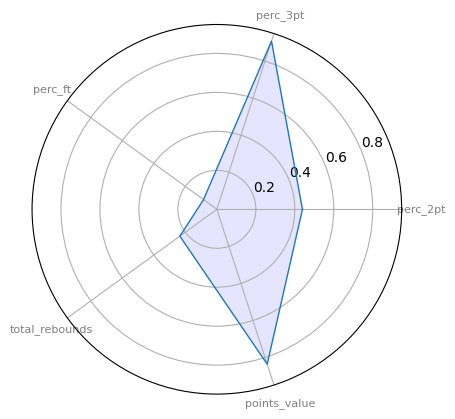

In [219]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

categories = list(normalized_df)[1:]
N = len(categories)

values=normalized_df.iloc[0].drop('teamTricode').values.flatten().tolist()
values += values[:1]
# values

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([".25",".5",".75"], [".25",".5",".75"], color="grey", size=7)
# plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

## Assit to dunk Analysis

In [6]:
final_df.columns

Index(['Unnamed: 0', 'actionNumber', 'clock', 'timeActual', 'period',
       'periodType', 'actionType', 'subType', 'qualifiers', 'personId', 'x',
       'y', 'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description',
       'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'shotDistance',
       'shotResult', 'pointsTotal', 'assistPlayerNameInitial',
       'assistPersonId', 'assistTotal', 'blockPlayerName', 'blockPersonId',
       'shotActionNumber', 'reboundTotal', 'reboundDefensiveTotal',
       'reboundOffensiveTotal', 'turnoverTotal', 'stealPlayerName',
       'stealPersonId', 'officialId', 'foulPersonalTotal',
       'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId',
       'value', 'gam

In [4]:
#looking into what player has assisted the most dunks in the nba (or per team)
assists = final_df[(final_df.subType == 'DUNK') & (pd.notnull(final_df.assistPlayerNameInitial) != True)].loc[:,['assistPlayerNameInitial','playerNameI','teamTricode', 'teamId', '' ]]

In [ ]:
#adding new col with combined player
# assists = assists[pd.notnull(assists.assistPlayerNameInitial)]

In [5]:
assists['assistor-assiste'] = assists.assistPlayerNameInitial + '_to_' + assists.playerNameI  

In [ ]:
# assists.columns()

In [ ]:
assistsfinal = assists.loc[: ,['teamTricode','assistor-assiste']].sort_values(by=['teamTricode'])

In [ ]:
assists_grouped = assistsfinal.groupby(['teamTricode','assistor-assiste'])['assistor-assiste'].count()

In [ ]:
assists_grouped

teamTricode  assistor-assiste               
ATL          B. Bogdanovic  to  C. Capela       6
             B. Bogdanovic  to  D. Gallinari    3
             B. Bogdanovic  to  D. Hunter       3
             B. Bogdanovic  to  J. Collins      1
             B. Bogdanovic  to  J. Johnson      1
                                               ..
WAS          T. Satoransky  to  C. Kispert      2
             T. Satoransky  to  D. Gafford      5
             T. Satoransky  to  K. Porzingis    6
             T. Satoransky  to  R. Hachimura    4
             T. Satoransky  to  T. Bryant       1
Name: assistor-assiste, Length: 2570, dtype: int64